In [33]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [15]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations

In [105]:
ANNOTATION_PATH = "E:/me/my Projects/dataset/cv/annotations"
xml_files = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(ANNOTATION_PATH)]

data = []
for xml_file in xml_files:
    annotations = parse_xml(xml_file)

    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])
df.head()

,filename,label,bbox
0,maksssksksss0.png,without_mask,"{'xmin': 79, 'ymin': 105, 'xmax': 109, 'ymax':..."
1,maksssksksss0.png,with_mask,"{'xmin': 185, 'ymin': 100, 'xmax': 226, 'ymax'..."
2,maksssksksss0.png,without_mask,"{'xmin': 325, 'ymin': 90, 'xmax': 360, 'ymax':..."
3,maksssksksss1.png,with_mask,"{'xmin': 321, 'ymin': 34, 'xmax': 354, 'ymax':..."
4,maksssksksss1.png,with_mask,"{'xmin': 224, 'ymin': 38, 'xmax': 261, 'ymax':..."


In [19]:
df['label'].value_counts()


label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64

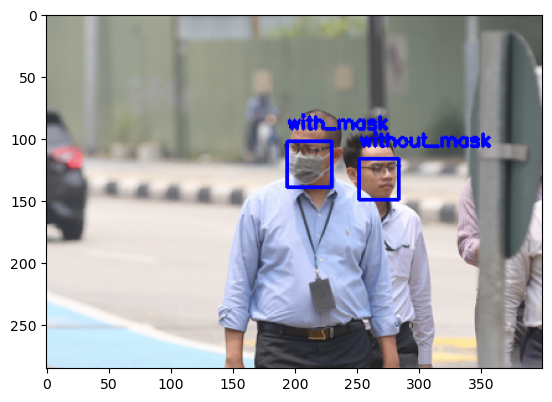

In [21]:
def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)

    for ann in annotations:
        bbox = ann['bbox']
        cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), (255, 0, 0), 2)
        cv2.putText(image, ann['label'], (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
visualize_annotation("E:/me/my Projects/dataset/cv/images/maksssksksss38.png", parse_xml('E:/me/my Projects/dataset/cv/annotations/maksssksksss38.xml'))

In [23]:
def apply_segmentation_array(image_array):
    if image_array is None or image_array.shape[0] == 0 or image_array.shape[1] == 0:
        return np.zeros((224, 224, 3), dtype=np.uint8)

    mask = np.zeros(image_array.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    h, w = image_array.shape[:2]
    rect = (10, 10, w - 20, h - 20)

    try:
        cv2.grabCut(image_array, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
        segmented = image_array * mask2[:, :, np.newaxis]
        return segmented
    except:
        return image_array


In [25]:
IMAGE_PATH = 'E:/me/my Projects/dataset/cv/images/'

label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}

face_images = []
face_labels = []

for i in range(len(df)):
    row = df.iloc[i]
    bbox = row['bbox']
    image = cv2.imread(IMAGE_PATH + row['filename'])

    if image is None:
        continue

    face = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
    if face.size == 0:
        continue

    face = cv2.resize(face, (224, 224))
    face = apply_segmentation_array(face)

    face = cv2.resize(face, (224, 224))
    face = cv2.GaussianBlur(face, (5, 5), 0)

    lab = cv2.cvtColor(face, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    lab_merged = cv2.merge((cl, a, b))
    face = cv2.cvtColor(lab_merged, cv2.COLOR_LAB2RGB)

    face = img_to_array(face)
    face = face.astype('float32') / 255.0

    face_images.append(face)
    face_labels.append(label_pair[row['label']])

face_images = np.array(face_images, dtype='float32')
face_labels = np.array(face_labels)

In [26]:
augmentation = ImageDataGenerator(
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=25,
    fill_mode='nearest'
)

In [27]:
train_x, test_x, train_y, test_y = train_test_split(face_images, face_labels, test_size=0.2, random_state=42, stratify=face_labels)

In [35]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
) 

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,979,907 (11.37 MB)

 Trainable params: 721,923 (2.75 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [39]:
history = model.fit(
    augmentation.flow(train_x, train_y, batch_size=16),
    validation_data=(test_x, test_y),
    epochs=15,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 103s 453ms/step - accuracy: 0.7845 - loss: 0.5950 - val_accuracy: 0.8798 - val_loss: 0.3519 - learning_rate: 0.0010
Epoch 2/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 122s 584ms/step - accuracy: 0.8575 - loss: 0.3765 - val_accuracy: 0.8294 - val_loss: 0.4001 - learning_rate: 0.0010
Epoch 3/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 120s 575ms/step - accuracy: 0.8794 - loss: 0.3197 - val_accuracy: 0.8724 - val_loss: 0.3580 - learning_rate: 0.0010
Epoch 4/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 124s 596ms/step - accuracy: 0.8920 - loss: 0.2991 - val_accuracy: 0.9018 - val_loss: 0.2776 - learning_rate: 0.0010
Epoch 5/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 121s 583ms/step - accuracy: 0.8895 - loss: 0.3054 - val_accuracy: 0.7963 - val_loss: 0.4432 - learning_rate: 0.0010
Epoch 6/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 120s 574ms/step - accuracy: 0.8785 - loss: 0.3247 - val_accuracy: 0.8834 - val_loss: 0.2982 - learning_rate: 0.0010
Epoch 7/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 121s 581ms/step - accura

26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 438ms/step - accuracy: 0.8967 - loss: 0.2867
Test Loss: 0.2776295244693756
Test Accuracy: 0.9018405079841614
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 568ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       647
           1       0.80      0.80      0.80       143
           2       0.50      0.20      0.29        25

    accuracy                           0.90       815
   macro avg       0.74      0.65      0.68       815
weighted avg       0.89      0.90      0.90       815



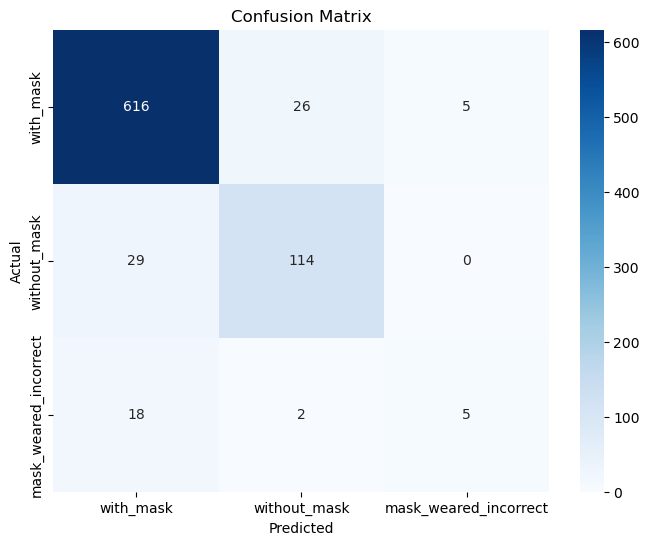

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(test_x)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(test_y, y_pred_labels))

cm = confusion_matrix(test_y, y_pred_labels)

label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}
label_pair_reversed = {v: k for k, v in label_pair.items()}

# رسم Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_pair_reversed.values(),
            yticklabels=label_pair_reversed.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [43]:
model.save('face_mask_detector.h5')


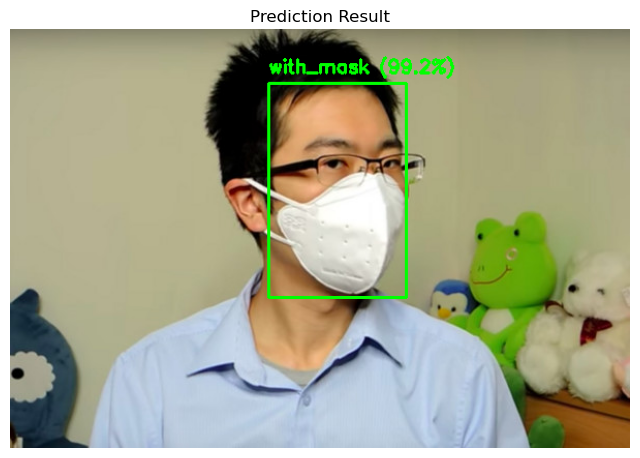

In [59]:
import os
import cv2
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import urllib.request

model_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
weights_url = "https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"

model_path = "deploy.prototxt"
weights_path = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(model_path):
    print("Downloading deploy.prototxt...")
    urllib.request.urlretrieve(model_url, model_path)

if not os.path.exists(weights_path):
    print("Downloading res10_300x300_ssd_iter_140000.caffemodel...")
    urllib.request.urlretrieve(weights_url, weights_path)

face_net = cv2.dnn.readNetFromCaffe(model_path, weights_path)
model = tf.keras.models.load_model("C:/Users/ABA/Downloads/face_mask_detector.h5")   

label_pair_reversed = {
    0: 'with_mask',
    1: 'without_mask',
    2: 'mask_weared_incorrect'
}

def preprocess_face(face):
    face = cv2.resize(face, (224, 224))

    # Gaussian Blur
    face = cv2.GaussianBlur(face, (5, 5), 0)

    # CLAHE
    lab = cv2.cvtColor(face, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    lab_merged = cv2.merge((cl, a, b))
    face = cv2.cvtColor(lab_merged, cv2.COLOR_LAB2RGB)

    # To array + Normalization manually
    face = img_to_array(face)
    face = face.astype('float32') / 255.0

    return face

def predict_image(filepath):
    image = cv2.imread(filepath)
    if image is None:
        print(f"image not found: {filepath}")
        return

    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
                                 mean=(104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    detected = False
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:   
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            face = image[startY:endY, startX:endX]
            if face.size == 0:
                continue

            face = preprocess_face(face)
            face = np.expand_dims(face, axis=0)

            prediction = model.predict(face, verbose=0)
            label_idx = np.argmax(prediction)
            label_text = label_pair_reversed[label_idx]
            confidence_percent = np.max(prediction) * 100

            color = (0, 255, 0) if label_idx == 0 else (0, 0, 255)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
            text = f"{label_text} ({confidence_percent:.1f}%)"
            cv2.putText(image, text, (startX, startY - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            detected = True

    if not detected:
        print("No faces detected in the image.")

    # عرض النتيجة
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Prediction Result")
    plt.show()

predict_image("E:/me/my Projects/dataset/cv/images/maksssksksss6.png")


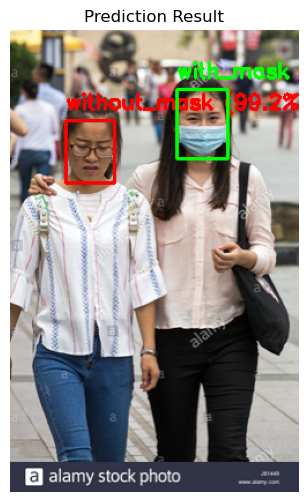

In [73]:
predict_image("E:/me/my Projects/dataset/cv/images/maksssksksss352.png")

In [75]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model_InceptionV3 = tf.keras.Model(inputs=base_model.input, outputs=x)

In [77]:
model_InceptionV3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [81]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)

model_InceptionV3.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 74,758,947 (285.18 MB)

 Trainable params: 52,956,163 (202.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [83]:
history = model_InceptionV3.fit(
    augmentation.flow(train_x, train_y, batch_size=16),
    validation_data=(test_x, test_y),
    epochs=15,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.7952 - loss: 5.5016 - val_accuracy: 0.9080 - val_loss: 0.2864 - learning_rate: 0.0010
Epoch 2/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.8855 - loss: 0.4006 - val_accuracy: 0.9117 - val_loss: 0.2430 - learning_rate: 0.0010
Epoch 3/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9019 - loss: 0.3177 - val_accuracy: 0.9104 - val_loss: 0.3173 - learning_rate: 0.0010
Epoch 4/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.9044 - loss: 0.3299 - val_accuracy: 0.8982 - val_loss: 0.3848 - learning_rate: 0.0010
Epoch 5/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9043 - loss: 0.3229 - val_accuracy: 0.9153 - val_loss: 0.2629 - learning_rate: 0.0010
Epoch 6/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.9188 - loss: 0.2807 - val_accuracy: 0.9239 - val_loss: 0.2715 - learning_rate: 0.0010
Epoch 7/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.9071 - loss: 0.

26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 891ms/step - accuracy: 0.9285 - loss: 0.2401
Test Loss: 0.19911260902881622
Test Accuracy: 0.9386503100395203
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       647
           1       0.89      0.91      0.90       143
           2       0.67      0.16      0.26        25

    accuracy                           0.94       815
   macro avg       0.84      0.68      0.71       815
weighted avg       0.93      0.94      0.93       815



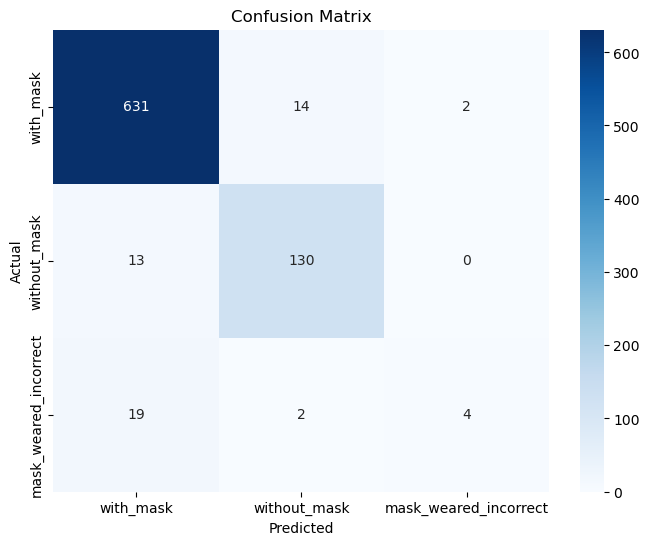

In [87]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_accuracy = model_InceptionV3.evaluate(test_x, test_y)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model_InceptionV3.predict(test_x)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(test_y, y_pred_labels))

cm = confusion_matrix(test_y, y_pred_labels)

label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}
label_pair_reversed = {v: k for k, v in label_pair.items()}

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_pair_reversed.values(),
            yticklabels=label_pair_reversed.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [89]:
model_InceptionV3.save('face_mask_model.h5')
print("Model saved successfully.")

Model saved successfully.


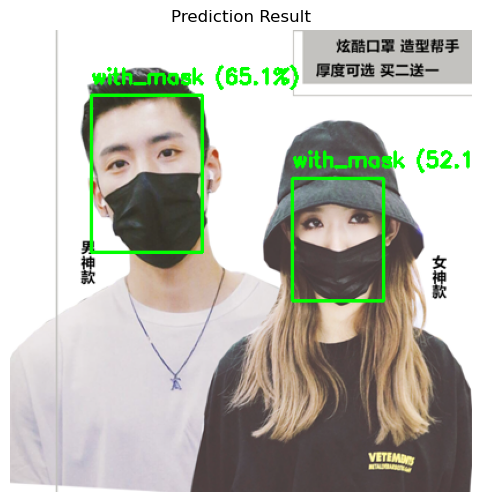

In [107]:
import os
import cv2
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import urllib.request

model_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
weights_url = "https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"

model_path = "deploy.prototxt"
weights_path = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(model_path):
    print("Downloading deploy.prototxt...")
    urllib.request.urlretrieve(model_url, model_path)

if not os.path.exists(weights_path):
    print("Downloading res10_300x300_ssd_iter_140000.caffemodel...")
    urllib.request.urlretrieve(weights_url, weights_path)

face_net = cv2.dnn.readNetFromCaffe(model_path, weights_path)
model = tf.keras.models.load_model("C:/Users/ABA/Downloads/face_mask_model.h5")  

label_pair_reversed = {
    0: 'with_mask',
    1: 'without_mask',
    2: 'mask_weared_incorrect'
}

def preprocess_face(face):
    face = cv2.resize(face, (224, 224))

    face = cv2.GaussianBlur(face, (5, 5), 0)

    lab = cv2.cvtColor(face, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    lab_merged = cv2.merge((cl, a, b))
    face = cv2.cvtColor(lab_merged, cv2.COLOR_LAB2RGB)

    face = img_to_array(face)
    face = face.astype('float32') / 255.0

    return face

def predict_image(filepath):
    image = cv2.imread(filepath)
    if image is None:
        print(f"  image not found: {filepath}")
        return

    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
                                 mean=(104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    detected = False
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            face = image[startY:endY, startX:endX]
            if face.size == 0:
                continue

            face = preprocess_face(face)
            face = np.expand_dims(face, axis=0)

            prediction = model.predict(face, verbose=0)
            label_idx = np.argmax(prediction)
            label_text = label_pair_reversed[label_idx]
            confidence_percent = np.max(prediction) * 100

            color = (0, 255, 0) if label_idx == 0 else (0, 0, 255)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
            text = f"{label_text} ({confidence_percent:.1f}%)"
            cv2.putText(image, text, (startX, startY - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            detected = True

    if not detected:
        print("No faces detected in the image.")

    # عرض النتيجة
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Prediction Result")
    plt.show()

# === 5. اختبار الدالة ===
predict_image("E:/me/my Projects/dataset/cv/images/maksssksksss26.png")


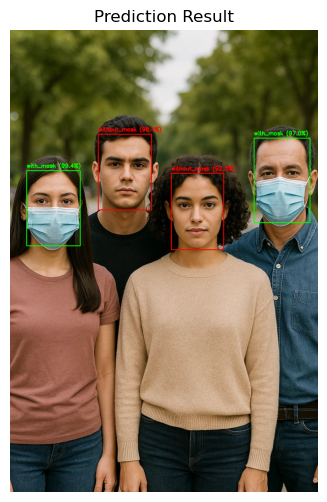

In [109]:
predict_image("C:/Users/ABA/Pictures/Saved Pictures/1.webp")

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(3, activation='softmax')  
])


In [129]:
model_cnn.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,817,795 (98.49 MB)

 Trainable params: 25,817,347 (98.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [131]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)



In [133]:
history = model_cnn.fit(
    augmentation.flow(train_x, train_y, batch_size=16),
    validation_data=(test_x, test_y),
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 152s 710ms/step - accuracy: 0.7902 - loss: 7.3989 - val_accuracy: 0.7939 - val_loss: 8.0171 - learning_rate: 0.0010
Epoch 2/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 126s 614ms/step - accuracy: 0.8133 - loss: 3.1795 - val_accuracy: 0.8074 - val_loss: 0.6431 - learning_rate: 0.0010
Epoch 3/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 128s 622ms/step - accuracy: 0.8127 - loss: 1.5041 - val_accuracy: 0.6712 - val_loss: 2.0214 - learning_rate: 0.0010
Epoch 4/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 125s 605ms/step - accuracy: 0.8159 - loss: 1.5193 - val_accuracy: 0.8798 - val_loss: 0.9655 - learning_rate: 0.0010
Epoch 5/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 126s 610ms/step - accuracy: 0.8209 - loss: 0.7390 - val_accuracy: 0.8896 - val_loss: 0.4200 - learning_rate: 0.0010
Epoch 6/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 126s 613ms/step - accuracy: 0.8326 - loss: 0.5211 - val_accuracy: 0.9190 - val_loss: 0.3898 - learning_rate: 0.0010
Epoch 7/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 125s 605ms/step - accura

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9110 - loss: 0.2496
Test Loss: 0.2224084734916687
Test Accuracy: 0.9276073575019836
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       647
           1       0.87      0.86      0.87       143
           2       0.00      0.00      0.00        25

    accuracy                           0.93       815
   macro avg       0.60      0.61      0.61       815
weighted avg       0.90      0.93      0.91       815



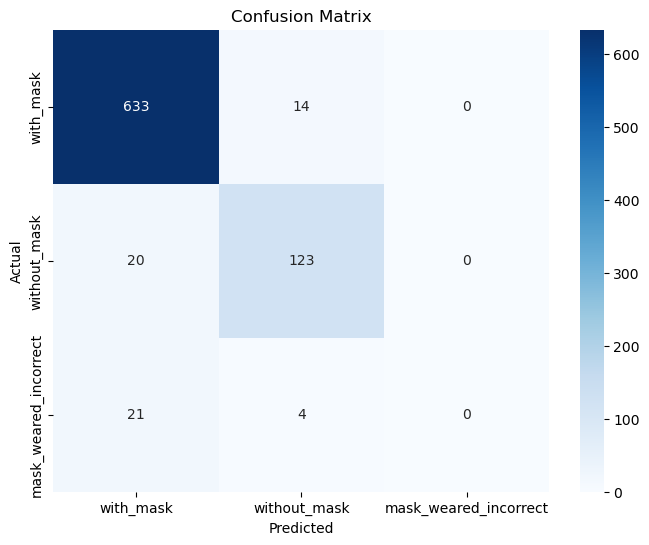

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_accuracy = model_cnn.evaluate(test_x, test_y)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model_cnn.predict(test_x)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(test_y, y_pred_labels))

cm = confusion_matrix(test_y, y_pred_labels)

label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}
label_pair_reversed = {v: k for k, v in label_pair.items()}

# رسم Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_pair_reversed.values(),
            yticklabels=label_pair_reversed.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


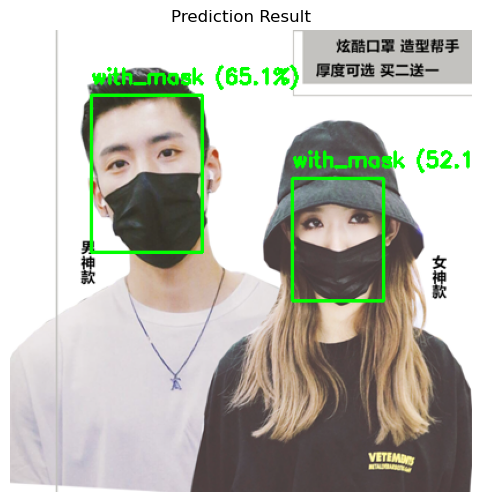

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import urllib.request

model_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
weights_url = "https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"

model_path = "deploy.prototxt"
weights_path = "res10_300x300_ssd_iter_140000.caffemodel"

if not os.path.exists(model_path):
    print("Downloading deploy.prototxt...")
    urllib.request.urlretrieve(model_url, model_path)

if not os.path.exists(weights_path):
    print("Downloading res10_300x300_ssd_iter_140000.caffemodel...")
    urllib.request.urlretrieve(weights_url, weights_path)

face_net = cv2.dnn.readNetFromCaffe(model_path, weights_path)
model = tf.keras.models.load_model("C:/Users/ABA/Downloads/model_cnn.h5") 

label_pair_reversed = {
    0: 'with_mask',
    1: 'without_mask',
    2: 'mask_weared_incorrect'
}

def preprocess_face(face):
    face = cv2.resize(face, (224, 224))

    # Gaussian Blur
    face = cv2.GaussianBlur(face, (5, 5), 0)

    # CLAHE
    lab = cv2.cvtColor(face, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    lab_merged = cv2.merge((cl, a, b))
    face = cv2.cvtColor(lab_merged, cv2.COLOR_LAB2RGB)

    # To array + Normalization manually
    face = img_to_array(face)
    face = face.astype('float32') / 255.0

    return face

def predict_image(filepath):
    image = cv2.imread(filepath)
    if image is None:
        print(f"image not found: {filepath}")
        return

    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
                                 mean=(104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    detected = False
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.4:  
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            face = image[startY:endY, startX:endX]
            if face.size == 0:
                continue

            face = preprocess_face(face)
            face = np.expand_dims(face, axis=0)

            prediction = model.predict(face, verbose=0)
            label_idx = np.argmax(prediction)
            label_text = label_pair_reversed[label_idx]
            confidence_percent = np.max(prediction) * 100

            color = (0, 255, 0) if label_idx == 0 else (0, 0, 255)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
            text = f"{label_text} ({confidence_percent:.1f}%)"
            cv2.putText(image, text, (startX, startY - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            detected = True

    if not detected:
        print("No faces detected in the image.")

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Prediction Result")
    plt.show()

predict_image("E:/me/my Projects/dataset/cv/images/maksssksksss26.png")
